In [1]:
! nvidia-smi

Wed May  6 11:29:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      1MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install

ติดตั้ง Library Transformers จาก HuggingFace

In [0]:
! pip install transformers -q
! pip install fastai2 -q

# Import

เราจะ Import 

In [0]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Download Pre-trained Model

ดาวน์โหลด Weight ของโมเดล ที่เทรนไว้เรียบร้อยแล้ว ชื่อ GPT2 

In [0]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

ใช้ Tokenizer ตัดตำ โดย Tokenizer ของ HuggingFace นี้ encode จะ Tokenize แปลงเป็น ตัวเลข Numericalize ในขั้นตอนเดียว

In [5]:
ids = tokenizer.encode("A lab at Florida Atlantic University is simulating a human cough")
ids

Using pad_token, but it is not set yet.


[32, 2248, 379, 4744, 10596, 2059, 318, 985, 8306, 257, 1692, 22094]

หรือ เราสามารถแยกเป็น 2 Step ได้

In [0]:
# toks = tokenizer.tokenize("A lab at Florida Atlantic University is simulating a human cough")
# toks, tokenizer.convert_tokens_to_ids(toks)

decode กลับเป็นข้อความต้นฉบับ

In [7]:
tokenizer.decode(ids)

'A lab at Florida Atlantic University is simulating a human cough'

# Generate text

In [8]:
import torch
t = torch.LongTensor(ids)[None]

preds = model.generate(t)
preds.shape

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


torch.Size([1, 20])

In [9]:
preds[0]

tensor([   32,  2248,   379,  4744, 10596,  2059,   318,   985,  8306,   257,
         1692, 22094,   351,   257,  3644,  1430,   326,   460,  4331,   262])

In [10]:
tokenizer.decode(preds[0].numpy())

'A lab at Florida Atlantic University is simulating a human cough with a computer program that can predict the'

# Fastai

In [0]:
from fastai2.text.all import *

In [12]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('/root/.fastai/data/wikitext-2/train.csv'),Path('/root/.fastai/data/wikitext-2/test.csv')]

In [13]:
df_train = pd.read_csv(path/"train.csv", header=None)
df_valid = pd.read_csv(path/"test.csv", header=None)
df_train.head()

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


In [14]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])
len(all_texts)

662

# Creating TransformersTokenizer Transform

เราจะนำ Tokenizer ของ Transformer มาสร้าง Transform ใน fastai ด้วยการกำหนด encodes, decodes และ setups    

In [0]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

ใน encodes เราจะไม่ได้ใช้ tokenizer.encode เนื่องจากภายในนั้น มีการ preprocessing นอกจาก tokenize และ numericalize ที่เรายังไม่ต้องการในขณะนี้ และ decodes จะ return TitledStr แทนที่ string เฉย ๆ จะได้รองรับ show method

In [0]:
# list(range_of(df_train))
# list(range(len(df_train), len(all_texts)))

เราจะเอา Transform ที่สร้างด้านบน ไปใส่ TfmdLists โดย split ตามลำดับที่ concat ไว้ และ กำหนด dl_type DataLoader Type เป็น LMDataLoader สำหรับใช้ในงาน Lanugage Model



In [0]:
splits = [list(range_of(df_train)), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
# tls

ดูข้อมูล Record แรก ของ Training Set

In [18]:
tls.train[0].shape, tls.train[0]

(torch.Size([4576]), tensor([220, 198, 796,  ..., 198, 220, 198]))

ดูเป็นข้อมูล ที่ decode แล้ว 

In [0]:
# show_at(tls.train, 0)

ดูข้อมูล Record แรก ของ Validation Set

In [20]:
tls.valid[0].shape, tls.valid[0]

(torch.Size([1485]), tensor([220, 198, 796,  ..., 198, 220, 198]))

ดูเป็นข้อมูล ที่ decode แล้ว 

In [0]:
# show_at(tls.valid, 0)

# DataLoaders

สร้าง DataLoaders เพื่อส่งให้กับ Model ด้วย Batch Size ขนาด 64 และ Sequence Length 1024 ตามที่ GPT2 ใช้

In [22]:
bs, sl = 4, 1024
dls = tls.dataloaders(bs=bs, seq_len=sl)
dls

In [23]:
dls.show_batch(max_n=5)

,text,text_
0,"\n = Italian cruiser Aretusa = \n \n Aretusa was a torpedo cruiser of the <unk> class built for the Italian Regia Marina ( Royal Navy ) in the 1880s. <unk> down in June 1889 at the <unk> <unk> <unk> Orlando shipyard, she was launched in March 1891 and was commissioned in September 1892. Her main armament were her six torpedo tubes, which were supported by a battery of ten small @-@ caliber guns. Aretusa spent most of her career in the main Italian fleet, where she was primarily occupied with training exercises. At the start of the Italo @-@ Turkish War in September 1911, she was assigned to the Red Sea Squadron in Italian Eritrea. She bombarded Ottoman positions in the Arabian Peninsula and took part in a blockade of the coast. <unk> out by the end of the war in October 1912, Aretusa was sold for scrap","\n = Italian cruiser Aretusa = \n \n Aretusa was a torpedo cruiser of the <unk> class built for the Italian Regia Marina ( Royal Navy ) in the 1880s. <unk> down in June 1889 at the <unk> <unk> <unk> Orlando shipyard, she was launched in March 1891 and was commissioned in September 1892. Her main armament were her six torpedo tubes, which were supported by a battery of ten small @-@ caliber guns. Aretusa spent most of her career in the main Italian fleet, where she was primarily occupied with training exercises. At the start of the Italo @-@ Turkish War in September 1911, she was assigned to the Red Sea Squadron in Italian Eritrea. She bombarded Ottoman positions in the Arabian Peninsula and took part in a blockade of the coast. <unk> out by the end of the war in October 1912, Aretusa was sold for scrap that"
1,"an interview with Billboard, RCA marketing executive Aaron <unk> remarked that the album was their main release of the holidays, quoting "" The angle on this album is that, like all great Christmas records, it's about amazing vocal performances. That's what this is intended to be @-@ an album launched this year but <unk> and genre @-@ <unk>. "" In preparation for its release in the United States, RCA shipped a half @-@ million units on Amazon.com and Target, which exclusively released a deluxe edition. A red LP pressing of Wrapped in Red by United Record <unk> followed the CD release on November 25, 2013, marking the first time an album by Clarkson was released on a vinyl record. A deluxe LP and CD edition was also released on the Sony Music store which included a scarf, a holiday ornament, and a snow globe, all of which were decorated","interview with Billboard, RCA marketing executive Aaron <unk> remarked that the album was their main release of the holidays, quoting "" The angle on this album is that, like all great Christmas records, it's about amazing vocal performances. That's what this is intended to be @-@ an album launched this year but <unk> and genre @-@ <unk>. "" In preparation for its release in the United States, RCA shipped a half @-@ million units on Amazon.com and Target, which exclusively released a deluxe edition. A red LP pressing of Wrapped in Red by United Record <unk> followed the CD release on November 25, 2013, marking the first time an album by Clarkson was released on a vinyl record. A deluxe LP and CD edition was also released on the Sony Music store which included a scarf, a holiday ornament, and a snow globe, all of which were decorated in"
2,"he <unk> up "" without a voice "". There was no intent to cancel, and the show went ahead as planned. Though Bono had few difficulties through the opening quartet of "" <unk> "", "" I Will Follow "", "" Gone "", and "" Even Better Than the Real Thing "", his voice gave out during "" Last Night on Earth "". In 2006, The Edge suggested that Bono's vocal troubles had been caused by <unk> or by the stress of the previous few months of touring, though he later remarked that "" it didn 't really matter that our lead singer was under the weather because every member of the audience seemed to join in on every song. There was a mass chorus for t

จะได้ DataLoader สำหรับ Lanugage Model ที่มี input และ label เหลื่อมกันอยู่ 1 Token สำหรับให้โมเดล Predict คำต่อไปของประโยค

# Preprocessing ไว้ก่อนให้หมด

อีกวิธีนึงคือ เราสามารถ Preprocessing ข้อมูลทั้งหมดไว้ก่อนได้เลย

In [0]:
# def tokenize(text):
#     toks = tokenizer.tokenize(text)
#     return tensor(tokenizer.convert_tokens_to_ids(toks))

# tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [0]:
# len(tokenized), tokenized[0]

เราจะประกาศ TransformersTokenizer ใหม่ ให้ใน encodes ไม่ต้องทำอะไร (แต่ถ้าไม่เป็น Tensor มาก็ให้ tokenize ใหม่)

In [0]:
# class TransformersTokenizer(Transform):
#     def __init__(self, tokenizer): self.tokenizer = tokenizer
#     def encodes(self, x): 
#         return x if isinstance(x, Tensor) else tokenize(x)
#     def decodes(self, x):
#         return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

แล้วจึงสร้าง TfmdLists โดยส่ง tokenized (ข้อมูลทั้งหมดที่ถูก tokenize เรียบร้อยแล้ว) เข้าไป

In [0]:
# tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
# dls = tls.dataloaders(bs=bs, seq_len=sl)

In [0]:
# dls.show_batch(max_n=5)

# Fine-tune Model

เนื่องจากโมเดลของ HuggingFace นั่น return output เป็น Tuple ที่ประกอบด้วย Prediction และ Activation เพิ่มเติมอื่น ๆ สำหรับใช้ในงานอื่น ๆ แต่ในเคสนี้เรายังไม่ต้องการ ทำให้เราต้องสร้าง after_pred Callback มาคั่นเพื่อเปลี่ยนให้ return แต่ Prediction เพื่อส่งไปให้กับ Loss Function ทำงานได้ตามปกติเหมือนเดิม

In [0]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

ใน callback เราสามารถอ้างถึง Prediction ของโมเดล ได้ด้วย self.pred ได้เลย แต่จะเป็นการ Read-only ถ้าต้องการ Write ต้องอ้างเต็ม ๆ ด้วย self.learn.pred

ตอนนี้เราสามารถสร้าง learner เพื่อเทรนโมเดลได้แล้ว

In [0]:
learn = None

In [0]:
torch.cuda.empty_cache()

In [0]:
Perplexity??

In [33]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
learn

ดูประสิทธิภาพของโมเดล ก่อนที่จะ Fine-tuned ตัวเลขแรกคือ Validation Loss ตัวที่สอง คือ Metrics ในที่นี้คือ Perplexity

In [34]:
learn.validate()

(#2) [3.25368332862854,25.885509490966797]

ได้ Perplexity 25.6 คือไม่เลวเลยทีเดียว

# Training

ก่อนเริ่มต้นเทรน เราจะเรียก lr_find หา Learning Rate กันก่อน

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

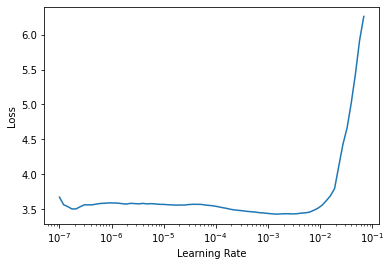

In [35]:
learn.lr_find()

แล้วเทรนไปแค่ 1 Epoch 

In [36]:
learn.fit_one_cycle(1, 3e-5)

epoch,train_loss,valid_loss,perplexity,time
0,3.658444,3.253683,25.885509,08:18


เราเทรนไปแค่ 1 Epoch โดยไม่ได้ปรับอะไรเลย โมเดลไม่ได้ประสิทธิภาพดีขึ้นสักเท่าไร เพราะมันดีมากอยู่แล้ว ต่อมาเราจะมาลองใช้โมเดล generate ข้อความดู ดังรูปแบบตัวอย่างใน Validation Set

In [37]:
df_valid.head(1)

,0
0,"\n = Tropical Storm <unk> ( 2008 ) = \n \n Tropical Storm <unk> was the tenth tropical storm of the 2008 Atlantic hurricane season . <unk> developed out of a strong tropical wave which moved off the African coast on August 31 . The wave quickly became organized and was declared Tropical Depression Ten while located 170 mi ( 270 km ) to the south @-@ southeast of the Cape Verde Islands on September 2 . The depression was quickly upgraded to Tropical Storm <unk> around noon the same day . Over the next several days , <unk> moved in a general west @-@ northwest direction and reached its peak..."


In [0]:
prompt = "\n = Modern economy = \n \n The modern economy is driven by data, and that trend is being accelerated by"

In [66]:
prompt_ids = tokenizer.encode(prompt)
# prompt_ids

Using pad_token, but it is not set yet.


In [67]:
inp = torch.LongTensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 24])

In [68]:
preds = learn.model.generate(inp, max_length=50, num_beams=5, temperature=1.6)
preds.shape

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


torch.Size([1, 50])

In [69]:
preds[0]

tensor([  198,   796, 12495,  3773,   796,   220,   198,   220,   198,   383,
         3660,  3773,   318,  7986,   416,  1366,    11,   290,   326,  5182,
          318,   852, 23312,   416,   649,  8514,    13,   198,   198,   818,
          262,  1613,  1178,   812,    11,   612,   468,   635,   587,   281,
         2620,   287,   262,  1271,   286,   661,   508,   670,   287,   262],
       device='cuda:0')

In [70]:
tokenizer.decode(preds[0].cpu().numpy())

'\n = Modern economy = \n \n The modern economy is driven by data, and that trend is being accelerated by new technologies.\n\nIn the past few years, there has also been an increase in the number of people who work in the'

# Credit

* https://dev.fast.ai/tutorial.transformers
* https://github.com/huggingface/transformers